In [2]:
from PIL import Image
import numpy as np
import os
import pandas as pd
from tqdm.notebook import tqdm 
import matplotlib.pyplot as plt

### Načtení dat
Funkce načte obrazy a metadata z definovaných cest a vrátila by je jako Numpy pole. Pak bychom mohli tyto data použít při trénování modelu GAN, přičemž bychom mohli model upravit tak, aby byl podmíněný, což znamená, že by generoval obrazy na základě zadání metadat (např. generování obrazu žilního řečiště pro muže ve věku 25 let, který je kuřákem).

In [3]:
from PIL import Image
import numpy as np
import os
import pandas as pd
from pathlib import Path

def load_data(metadata_path, data_directory, num_folders=2):
    metadata = pd.read_excel(metadata_path)
    
    images = []
    labels = []
    
    # Count total images in the dataset directory
    total_images = sum(1 for _ in Path(data_directory).rglob('*.png'))
    
    finger_folders = ["l_index", "l_little", "l_middle", "l_ring", "l_thumb", 
                      "r_index", "r_little", "r_middle", "r_ring", "r_thumb"]
    
    progress_bar = tqdm(total=total_images, desc='Loading images', dynamic_ncols=True)
    
    for index, row in metadata.iterrows():
        if index >= num_folders:
            break
            
        for finger_folder in finger_folders:
            folder_path = Path(data_directory) / str(row['id']) / finger_folder
            
            if folder_path.exists():
                image_files = list(folder_path.glob("*.png"))
                
                for img_path in image_files:
                    img = Image.open(img_path)
                    img = np.array(img)
                    
                    images.append(img)
                    
                    label = {
                        'id': row['id'],
                        'gender': row['gender'],
                        'age': row['age'],
                        'melanin': row['melanin'],
                        'cardiovascular_disease': row['cardiovascular disease'],
                        'smoker': row['smoker'],
                        'sport_hobby_with_fingers': row['sport/hobby with fingers'],
                        'alcohol_before_scan': row['alcohol before scan'],
                        'skin_disease': row['skin disease'],
                        'finger': finger_folder
                    }
                    labels.append(label)
                    progress_bar.update(1)
                
    progress_bar.close()
    return np.array(images), labels

# You can call this function to load the data:
images, labels = load_data("data_description.xlsx", "dataset")



Loading images:   0%|          | 0/1458 [00:00<?, ?it/s]

### Images preprocessing

In [5]:
from skimage import exposure
import numpy as np

from skimage import morphology, filters, util
from skimage.color import rgb2gray
from skimage import io, color
from PIL import Image
import random
from sklearn.preprocessing import OneHotEncoder, LabelEncoder


# Function to preprocess a single image
def preprocess_image(image, target_size=(1024, 1024)):
    # Convert image to numpy array if not already
    img_array = np.array(image)

    # Check if the image has an alpha channel (transparency)
    if img_array.shape[-1] == 4:
        # Convert to RGB first, then grayscale
        grayscale_img = color.rgb2gray(img_array[..., :3])
    elif img_array.shape[-1] == 3:
        # Convert to grayscale
        grayscale_img = color.rgb2gray(img_array)
    else:
        # Image is already grayscale
        grayscale_img = img_array

    # Apply histogram equalization
    equalized_img = exposure.equalize_adapthist(grayscale_img, clip_limit=0.03)

    # Scale the image to range [-1, 1]
    scaled_img = (equalized_img * 2.0) - 1.0  # This scales the 0-1 range to -1 to 1

    # Convert scaled image back to a PIL image for further processing
    processed_image = Image.fromarray(np.uint8((scaled_img + 1) * 0.5 * 255), mode='L')

    original_size = processed_image.size
    ratio = min(target_size[0]/original_size[0], target_size[1]/original_size[1])
    new_size = (int(original_size[0] * ratio), int(original_size[1] * ratio))

    # Resize the image using the calculated size
    processed_image = processed_image.resize(new_size, Image.Resampling.LANCZOS)

    # Create a new image with the target size and a black background
    new_image = Image.new("L", target_size)

    # Paste the resized image onto the center of the new image
    new_image.paste(processed_image, ((target_size[0] - new_size[0]) // 2, (target_size[1] - new_size[1]) // 2))

    return new_image

def preprocess_labels(labels):
    # Assuming all dicts have the same structure
    keys = labels[0].keys()
    label_data = {key: np.array([dic[key] for dic in labels]) for key in keys}

    # Initialize encoders
    one_hot_encoder = OneHotEncoder()
    label_encoder = LabelEncoder()

    # Process categorical data
    categorical_keys = ['gender', 'smoker', 'sport_hobby_with_fingers', 'alcohol_before_scan', 'skin_disease', 'finger']
    categorical_data = np.stack([label_data[key] for key in categorical_keys], axis=1)
    categorical_data_encoded = one_hot_encoder.fit_transform(categorical_data).toarray()

    # Process numerical/ordinal data
    numerical_keys = ['age']
    numerical_data = np.stack([label_data[key] for key in numerical_keys], axis=1)

    # Process data that may require custom encoding like 'melanin', 'cardiovascular_disease'
    # For example, melanin might be encoded based on the count of 'L' and 'R' occurrences, or any domain-specific method
    # cardiovascular_disease might be one-hot encoded if it has standard categories, or label-encoded if it's more like a ranking

    # For now, we'll just use the age directly and ignore other complex features for simplicity
    condition_input = np.concatenate([numerical_data, categorical_data_encoded], axis=1)

    return condition_input

# preprocess all images in the dataset


# shuffling the dataset helps to ensure that the training process does not become biased by the order of the data
random.shuffle(images)
# Display the original image
# plt.imshow(images[0])
# plt.axis('off')
# plt.title('Original Image')
# plt.show()

# processed_image = preprocess_image(images[0])
# # Display the preprocessed first image
# plt.imshow(processed_image, cmap='gray')
# plt.axis('off')
# plt.title('Enhanced Image')
# plt.show()



preprocessed_labels = preprocess_labels(labels[0:100])
preprocessed_images = np.stack([preprocess_image(image) for image in images[0:100]], axis=0)


print(preprocessed_images[0])
print(preprocessed_labels[0])


import pickle 

# save preprocessed data to pickle files

with open('preprocessed_images.pickle', 'wb') as f:
    pickle.dump(preprocessed_images, f)
    
    
with open('preprocessed_labels.pickle', 'wb') as f:
    pickle.dump(preprocessed_labels, f)
    
    
    


KeyboardInterrupt: 

### Model Implementation and Training

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose
from keras.optimizers import Adam

import tensorflow as tf
from tensorflow.keras import layers, models

# Generator
class Generator():
    
    def __init__(self, z_dim, condition_shape, img_shape):
        # z_dim: Dimension of the latent space (noise vector)
        # condition_shape: Shape of the condition input (e.g., parameters like age, blood pressure)
        # img_shape: Shape of the generated image output

        self.z_dim = z_dim
        self.condition_shape = condition_shape
        self.img_shape = img_shape

        self.model = self.build_generator()

    def build_generator(self):
        # Noise input (z_dim-dimensional latent vector)
        z_input = layers.Input(shape=(self.z_dim,))
        # Conditional input (additional information you want to condition the generation on)
        condition_input = layers.Input(shape=(self.condition_shape,))
        
        # Combine noise and condition via concatenation
        x = layers.Concatenate()([z_input, condition_input])
        
        # Fully connected layer that takes the combined input
        x = layers.Dense(256, activation='relu')(x)
        x = layers.BatchNormalization()(x)  # Helps to stabilize training
        
        # Up-sampling: Increasing the dimensionality to get to the correct image size
        x = layers.Dense(512, activation='relu')(x)
        x = layers.BatchNormalization()(x)  # Further stabilization of training
        # The final layer has a size of the product of the image dimensions (width * height * channels)
        x = layers.Dense(np.prod(self.img_shape), activation='tanh')(x)  # 'tanh' activation is common for GANs
        # Reshape the output to the size of the image
        img = layers.Reshape(self.img_shape)(x)
        
        # The generator model takes noise and condition as input and outputs an image
        generator = models.Model([z_input, condition_input], img, name='generator')

        return generator
    
class Discriminator():
    
    def __init__(self, img_shape, condition_shape):
        # img_shape: Shape of the input image
        # condition_shape: Shape of the condition input

        self.img_shape = img_shape
        self.condition_shape = condition_shape

        self.model = self.build_discriminator()

    def build_discriminator(self):
        # Image input (shape of the input image)
        img_input = layers.Input(shape=self.img_shape)
        # Conditional input (shape of the condition)
        condition_input = layers.Input(shape=self.condition_shape)

        # Combine image and condition via concatenation
        # We assume that condition input is a flat vector and needs to be expanded to the image size
        condition_input_expanded = layers.Dense(np.prod(self.img_shape))(condition_input)
        condition_input_expanded = layers.Reshape(self.img_shape)(condition_input_expanded)
        combined_input = layers.Concatenate()([img_input, condition_input_expanded])

        # Convolutional layers
        x = layers.Conv2D(64, kernel_size=3, strides=2, padding="same")(combined_input)
        x = layers.LeakyReLU(alpha=0.2)(x)
        x = layers.Dropout(0.3)(x)

        x = layers.Conv2D(128, kernel_size=3, strides=2, padding="same")(x)
        x = layers.LeakyReLU(alpha=0.2)(x)
        x = layers.Dropout(0.3)(x)

        # Flatten and add a dense layer
        x = layers.Flatten()(x)
        x = layers.Dense(1)(x)  # Not using sigmoid activation because it will be used in combination with a loss function that expects logits

        # Create the discriminator model
        discriminator = models.Model([img_input, condition_input], x, name='discriminator')

        return discriminator
    










### Load saved files

In [19]:
import pickle
import numpy as np
with open('preprocessed_images.pickle', 'rb') as f:
    preprocessed_images = pickle.load(f)

with open('preprocessed_labels.pickle', 'rb') as f:
    preprocessed_labels = pickle.load(f)
    
    
np.savetxt("image.txt", preprocessed_images[0], newline=" ")    
# dump one preprocessed image to txt file 


### Create smaller sample from images 


In [21]:
SAMPLE_LIMIT = 10

preprocessed_images = preprocessed_images[0:SAMPLE_LIMIT]
preprocessed_labels = preprocessed_labels[0:SAMPLE_LIMIT]

z_dim = 100  # This should match the z_dim you used to initialize your Generator
batch_size = preprocessed_images.shape[0]  # Or any other batch size you want to use
noise = np.random.normal(0, 1, (batch_size, z_dim))



### Generator testing

2023-11-09 14:00:10.437825: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2023-11-09 14:00:10.437883: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: poli
2023-11-09 14:00:10.437889: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: poli
2023-11-09 14:00:10.438114: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 525.147.5
2023-11-09 14:00:10.438139: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 525.125.6
2023-11-09 14:00:10.438145: E tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:312] kernel version 525.125.6 does not match DSO version 525.147.5 -- cannot find working devices in this configuration
2023-11-09 14:00:10.57

1/1 [==============================] - 0s 473ms/step


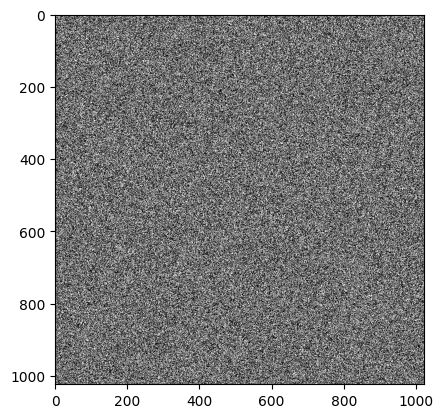

In [14]:

generator = Generator(z_dim, preprocessed_labels.shape[1], (1024 ,1024, 1))  # Adjust the image shape accordingly
synthetic_images = generator.model.predict([noise, preprocessed_labels])

# scale numpy array from values between 0 and 1 to values between 0 and 255
synthetic_images = (synthetic_images * 255).astype(np.uint8)

plt.imshow(synthetic_images[0], cmap='gray')

### Discriminator testing 


In [22]:
# Initialize the discriminator (make sure the img_shape matches the generator output)
discriminator = Discriminator(img_shape=(1024, 1024, 1), condition_shape=preprocessed_labels.shape[1])



# Prepare labels for real images (1s) and fake images (0s)
real_labels = np.ones((batch_size, 1))
fake_labels = np.zeros((batch_size, 1))

real_images = preprocessed_images .astype(np.float32)
fake_images = synthetic_images.astype(np.float32)


# Get discriminator predictions for fake images
fake_predictions = discriminator.model.predict([synthetic_images, preprocessed_labels])

# Get discriminator predictions for real images
real_predictions = discriminator.model.predict([real_images, preprocessed_labels])

# The predictions are logits; to interpret them as probabilities, you can use the sigmoid function
fake_probabilities = tf.sigmoid(fake_predictions)
real_probabilities = tf.sigmoid(real_predictions)

# print the probabilities

print(fake_probabilities)
print(real_probabilities)

1/1 [==============================] - 1s 656ms/step
tf.Tensor(
[[1.        ]
 [0.99999976]
 [0.99987596]
 [0.99995095]
 [1.        ]
 [1.        ]
 [0.9999999 ]
 [0.9999997 ]
 [0.9999998 ]
 [1.        ]], shape=(10, 1), dtype=float32)
tf.Tensor(
[[0.995798  ]
 [0.99767125]
 [0.99767125]
 [0.995798  ]
 [0.99877775]
 [0.99877775]
 [0.99877775]
 [0.99870604]
 [0.9996246 ]
 [0.9989626 ]], shape=(10, 1), dtype=float32)


### cGAN model

In [27]:
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
import numpy as np

# Assume Generator and Discriminator classes are already defined as per previous discussion

def build_cgan(generator, discriminator, z_dim, condition_shape):
    # Make sure only the generator is trainable
    discriminator.model.trainable = False

    # Inputs to the combined model
    z = layers.Input(shape=(z_dim,))
    condition = layers.Input(shape=(condition_shape,))
    
    # Generate an image based on noise and condition inputs
    img = generator.model([z, condition])
    
    # The discriminator takes the generated image as input and gives a probability
    valid = discriminator.model([img, condition])

    # The combined model (stacked generator and discriminator)
    cgan_model = models.Model([z, condition], valid, name='cgan')

    # Compile the combined model
    cgan_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

    return cgan_model

# Initialize the generator and discriminator
z_dim = 100
condition_shape = preprocessed_labels.shape[1]  
img_shape = (1024, 1024, 1)  # Example image shape, adjust as per your data
generator = Generator(z_dim, condition_shape, img_shape)
discriminator = Discriminator(img_shape, condition_shape)

# Build the cGAN model
cgan = build_cgan(generator, discriminator, z_dim, condition_shape)

# Now cgan is a model that, when trained, will update the generator's weights
# to try to "fool" the discriminator, while the discriminator's weights remain fixed


In [32]:
import numpy as np



discriminator.model.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])
cgan.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')


print("CGAN and Discriminator compiled")



epochs = 10  # Number of epochs to train for
batch_size = 1  # Size of the batch

# Convert labels to float32 for consistency
preprocessed_labels = preprocessed_labels.astype(np.float32)

# Get the number of batches per epoch
num_batches = int(preprocessed_images.shape[0] / batch_size)



for epoch in range(epochs):
    for batch in range(num_batches):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Get a batch of real images
        idx = np.random.randint(0, preprocessed_images.shape[0], batch_size)
        real_imgs = preprocessed_images[idx]
        labels = preprocessed_labels[idx]

        # Generate a batch of fake images
        noise = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.model.predict([noise, labels])

        # Labels for real and fake data
        valid_y = np.ones((batch_size, 1))
        fake_y = np.zeros((batch_size, 1))

        # Train the discriminator
        d_loss_real = discriminator.model.train_on_batch([real_imgs, labels], valid_y)
        d_loss_fake = discriminator.model.train_on_batch([gen_imgs, labels], fake_y)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        # We want the generator to trick the discriminator, so we label the generated images as real
        g_loss = cgan.train_on_batch([noise, labels], valid_y)

        # If at the end of the epoch, save models, print out stats, or adjust learning rates if necessary
        print(f"{epoch}/{epochs} [D loss: {d_loss[0]}, acc: {100*d_loss[1]}] [G loss: {g_loss}]")

# After training is complete, save your models
generator.model.save('generator_model.h5')
discriminator.model.save('discriminator_model.h5')

CGAN and Discriminator compiled
1/1 [==============================] - 0s 371ms/step
here
0/10 [D loss: 7.713096886815038, acc: 50.0] [G loss: 15.424948692321777]
1/1 [==============================] - 0s 364ms/step
here
